<h2>Question 1<\h2>
<h4>The reason<\h4>

In [1]:
%pylab

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import cv2
from helper import *
from itertools import product
from tqdm import tqdm

In [3]:
left = cv2.imread("A4_files/000020_left.jpg")
right = cv2.imread("A4_files/000020_right.jpg")
with open("A4_files/000020.txt") as file:
    x_min, y_min, x_max, y_max = [float(i) for i in file.read().split()[1:]]
with open("A4_files/000020_allcalib.txt") as file:
    f, px, py, baseline = file.read().split()[1::2]
print(x_min, y_min, x_max, y_max, f, px, py, baseline)

685.05 181.43 804.68 258.21 721.537700 609.559300 172.854000 0.5327119288


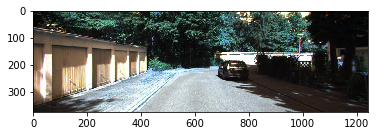

In [4]:
patchsize = 5
imshow(left)

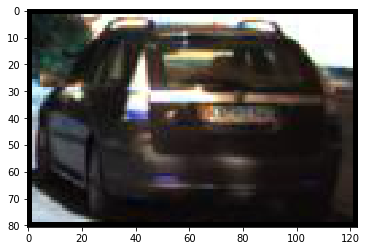

In [5]:
tar = left[int(y_min):int(y_max), int(x_min):int(x_max)]
tar = np.pad(tar, [[patchsize//2, patchsize//2], [patchsize//2, patchsize//2], [0, 0]])
imshow(tar)

### Q2
a. I am using SSD for this part

In [6]:
def SSD(patch1, patch2):
    return np.sum((patch1 - patch2)**2)
    
def rowler(patch, imgr, row_idx):
    patchsize = patch.shape[0]
    row = imgr[row_idx:row_idx+patchsize]
    ssd_list = []
    for i in range(row.shape[1]-patchsize+1):
        ssd_list.append(SSD(patch, imgr[row_idx:row_idx+patchsize, i:i+patchsize]))
    return np.array(ssd_list)

def disparity(imgl, imgr, y_min, x_min, patch_size):
    patch = imgl[y_min:y_min+patch_size, x_min:x_min+patch_size]
    row_idx = y_min
    ssd_list = rowler(patch, imgr, row_idx)
    x_min_r = ssd_list.argmin()
    return x_min - x_min_r

def dis_pad(img, patch_size):
    return np.pad(img, [[patch_size//2, patch_size//2], [patch_size//2, patch_size//2], [0, 0]])
    

In [7]:
imgl = tar
imgr = right
patch_size = 5
new_img = np.zeros_like(imgl)[..., 0]
for y, x in tqdm(list(product(range(imgl.shape[0]-patch_size+1), range(imgl.shape[1]-patch_size+1)))):
        new_img[y, x] = disparity(imgl, imgr, y, x, patch_size)

100%|██████████| 9163/9163 [01:58<00:00, 77.50it/s]


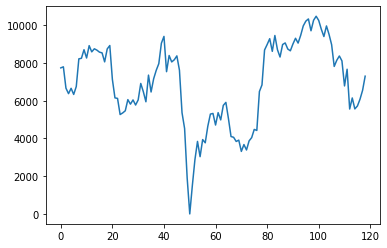

In [8]:
plot(rowler(tar[50:55, 50:55], tar, 50))

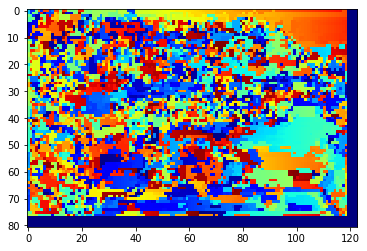

In [10]:
imshow(new_img, cmap=cm.jet)